## Boosting

### Julián D. Arias Londoño

Profesor Asociado  
Departamento de Ingeniería de Sistemas  
Universidad de Antioquia, Medellín, Colombia  
julian.ariasl@udea.edu.co

In [2]:
%matplotlib inline

Como vimos en la clase anterior, en Machine Learning los métodos de ensamble sigen la idea de entrenar múltiples modelos simples y combinar sus respuestas para producir un mejor resultado. A diferencia del Bagging en Boosting la combinación se hace de manera secuencial y no paralela:

![alt text](./Images/Boosting1.png "Boosting1")

La idea central de los métodos de Boosting es entrenar modelos secuencialmente haciendo que los modelos subsiguientes se enfoquen en las muestras que no han podido ser modeladas correctamente por los modelos anteriores. Cada modelo tiene un peso diferente dentro de la decisión final. La forma de asignar el peso a las muestras y a los clasificadores dependen del método de Boosting particular.

![alt text](./Images/Boosting2.png "Boosting2")

Imágenes tomadas de: https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/

Los dos métodos reducen el error por varianza; boosting es mejor para reducir el bias pero puede presentar problemas de sobreajuste, razón por la cual algunos métodos de boosting requieren un ajuste cuidados de parámetros de regularización.

### Adapting Boosting (Adaboost)

En Adaboost el modelo de ensamble se define como una suma sopesada de $M$ modelos débiles:

$$F({\bf{x}}) = \sum_{m=1}^M \alpha_m y_m({\bf{x}})$$

donde $\alpha_m$ son los pesos y $y_m(\cdot)$ son los modelos base.

El algoritmo de entrenamiento consiste en adicionar clasificadores débiles uno a la vez, en un proceso de optimización iterativo, tratando de encontrar en cada iteración el mejor par $(\alpha_m, y_m)$ para adicional al ensamble actual. 

Dado un conjunto de muestras de entrenamiento $\mathcal{D} = \{({\bf{x}}_n,t_n)\}_{n=1}^N$

![alt text](./Images/AdaBoostAlgorithm.png "AdaBoost")

La función indicador $1(\cdot)$ produce un 1 si la condición se cumple un -1 en caso contrario.

![alt text](./Images/AdaBoostAlgorithm2.png "AdaBoost")

Imagen tomada de: https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe

La modificación de los pesos a cada una de las muestras dentro del algoritmo AdaBoost puede ser aplicado de dos formas:

* Los pesos de cada muestra se pueden usar para establecer una nueva distribución $D_{m+1}(n) = \frac{D_{m}(n)\exp(-\alpha_m t_n y_m({\bf{x}}_n))}{Z_m}$, donde $Z_m$ es un factor de normalización que garantiza que la distribución cumplea la restricción estocástica $\sum_{\forall n} D_{m}(n) = 1$. Se puede usar un proceso de muestreo sobre la distribución $D_{m+1}$ en la cual tendrán mayor probabilidad de aparición las muestras sobre las que el modelo ha cometido más errores. Dicho muestreo se puede realizar fácilmente usando una distribución multinomial (numpy.random.multinomial).

* Los pesos de cada muestra se pueden usar con clasificadores base que puedan tratar cada muestra con una importancia diferente. En el caso de los árboles de decisión, se puede, por ejemplo, usar el peso de cada muestra para medir la ganancia de información. Cuando se estima la probabilidad de quedar a cada lado de una partición $a$, en lugar de contar 1 por cada muestra, se usa el peso de dicha muestra (sample_weight).

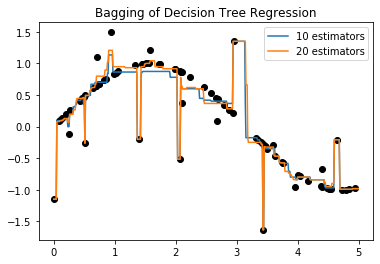

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
import numpy as np
import matplotlib.pyplot as plt
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
from sklearn.tree import DecisionTreeRegressor
clf_b = DecisionTreeRegressor(max_depth=5)
clf_1 = AdaBoostRegressor(base_estimator=clf_b, n_estimators=10, random_state=0).fit(X, y)
clf_2 = AdaBoostRegressor(base_estimator=clf_b, n_estimators=20, random_state=0).fit(X, y)
# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = clf_1.predict(X_test)
y_2 = clf_2.predict(X_test)

plt.plot(X,y,'o',color='black')
plt.plot(X_test,y_1,label='10 estimators')
plt.plot(X_test,y_2,label='20 estimators')
# Plot the resu  et")
plt.title("Bagging of Decision Tree Regression")
plt.legend()
plt.show()

### Gradient Bossting

Es un algoritmo de Boosting que aproxima el problema en poco diferente al caso anterior, en lugar de ajustar los pesos de las muestras, el Gradient Boosting se enfoca en la diferencia entre la predicción actual y el valor deseado (ground truth). El modelo global se define de la misma manera que en el caso anterior:

$$F({\bf{x}}) = \sum_{m=1}^M \alpha_m y_m({\bf{x}})$$


Sin embargo, en este caso el algoritmo minimiza el error a través de una forma de gradiente. La función de salida en el paso $m$ está dada por: 

$$F_m({\bf{x}}) = F_{m-1}({\bf{x}}) + \gamma_m y_m({\bf{x}})$$

El nuevo modelo $y_m$ intenta minimizar la función de pérdida:

$$y_m = \underset{y}{\mathrm{argmin}} \sum_{n=1}^N L(t_n,F_{m-1}({\bf{x}}_n) + y_m({\bf{x}}_n))$$

Para resolver el problema de optimización Gradient Boosting utiliza la regla del gradiente descendente dada por:

$$F_m({\bf{x}}) = F_{m-1}({\bf{x}}) - \gamma_m \sum_{n=1}^N \Delta_F L(t_n,F_{m-1}({\bf{x}})_n)$$

la cual puede ser calculada para cualquier función $F(\cdot)$ que sea derivable. La longitud del paso en el gradiente se estima como:

$$\gamma_m = \arg\min_{\gamma} \sum_{n=1}^{N} L(t_n, F_{m-1}({\bf{x}}_n) - \gamma \frac{\partial L(t_n, F_{m-1}({\bf{x}}_n))}{\partial F_{m-1}({\bf{x}}_n)})$$

Los algoritmos para clasificación y regresión sólo difieren en la función de opérdida $L$.

Aunque el Gradient Boosting puede ser implementado para cualquier clasificador base, el algoritmo más usado usa **árboles de decisión** como modelos base. 

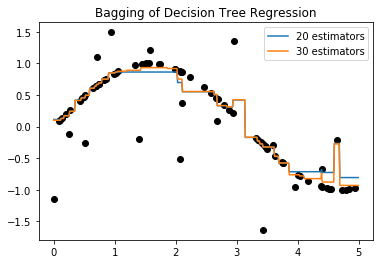

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
clf_1 = GradientBoostingRegressor(loss = 'lad', n_estimators=20, random_state=0).fit(X, y)
clf_2 = GradientBoostingRegressor(loss = 'lad', n_estimators=30, random_state=0).fit(X, y)
# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = clf_1.predict(X_test)
y_2 = clf_2.predict(X_test)

plt.plot(X,y,'o',color='black')
plt.plot(X_test,y_1,label='20 estimators')
plt.plot(X_test,y_2,label='30 estimators')
# Plot the resu  et")
plt.title("Bagging of Decision Tree Regression")
plt.legend()
plt.show()

### Consultar

* Stochastic Gradient Boosting Tree

Modificaciones recientes de gran interés:

* XGBoost
* LightGBM
* CatBoost

[CatBoost vs. Light GBM vs. XGBoost](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)